In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

In [2]:
with open("../data/aggregated_final/infections_np_nodil.pickle", "rb") as f:
    final_inf_np = pickle.load(f)
with open("../data/aggregated_final/infections_ccp_nodil.pickle", "rb") as f:
    final_inf_cp = pickle.load(f)

with open("../data/aggregated_final/testconsumption_np_nodil.pickle", "rb") as f:
    final_tests_np = pickle.load(f)
with open("../data/aggregated_final/testconsumption_ccp_nodil.pickle", "rb") as f:
    final_tests_cp = pickle.load(f)

In [3]:
diffs = {"infections": dict(), "tests": dict()}
sems = {"infections": dict(), "tests": dict()}

dilute_vals = ["average", "constant_0.8"]

diff_of_means_vals = {}
sem_of_diffs_vals = {}

first_n = 200

data = {
    "np": {"infections": final_inf_np, "tests": final_tests_np},
    "ccp": {"infections": final_inf_cp, "tests": final_tests_cp},
}

for metric in ["infections", "tests"]:
    if metric == "infections":
        final_np = final_inf_np
        final_cp = final_inf_cp
    else:
        final_np = final_tests_np
        final_cp = final_tests_cp

    for dilute, pm in itertools.product(dilute_vals, ["np", "ccp"]):
        diff_of_means_arr = np.zeros((7, 4))
        sem_of_diffs_arr = np.zeros((7, 4))

        for i, num_groups in enumerate(range(1, 8)):
            for j, pool_size in enumerate([5, 10, 15, 20]):

                diff_of_means_arr[i, j] = np.mean(
                    data[pm][metric][(num_groups, pool_size, dilute)][:first_n]
                )

        diffs[metric][(pm, dilute)] = diff_of_means_arr

## Figure 6

/tmp/ipykernel_446635/3766969361.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  color=colors[cell_color_0[0] < 0.5],
/tmp/ipykernel_446635/3766969361.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  color=colors[cell_color_1[0] < 0.5],


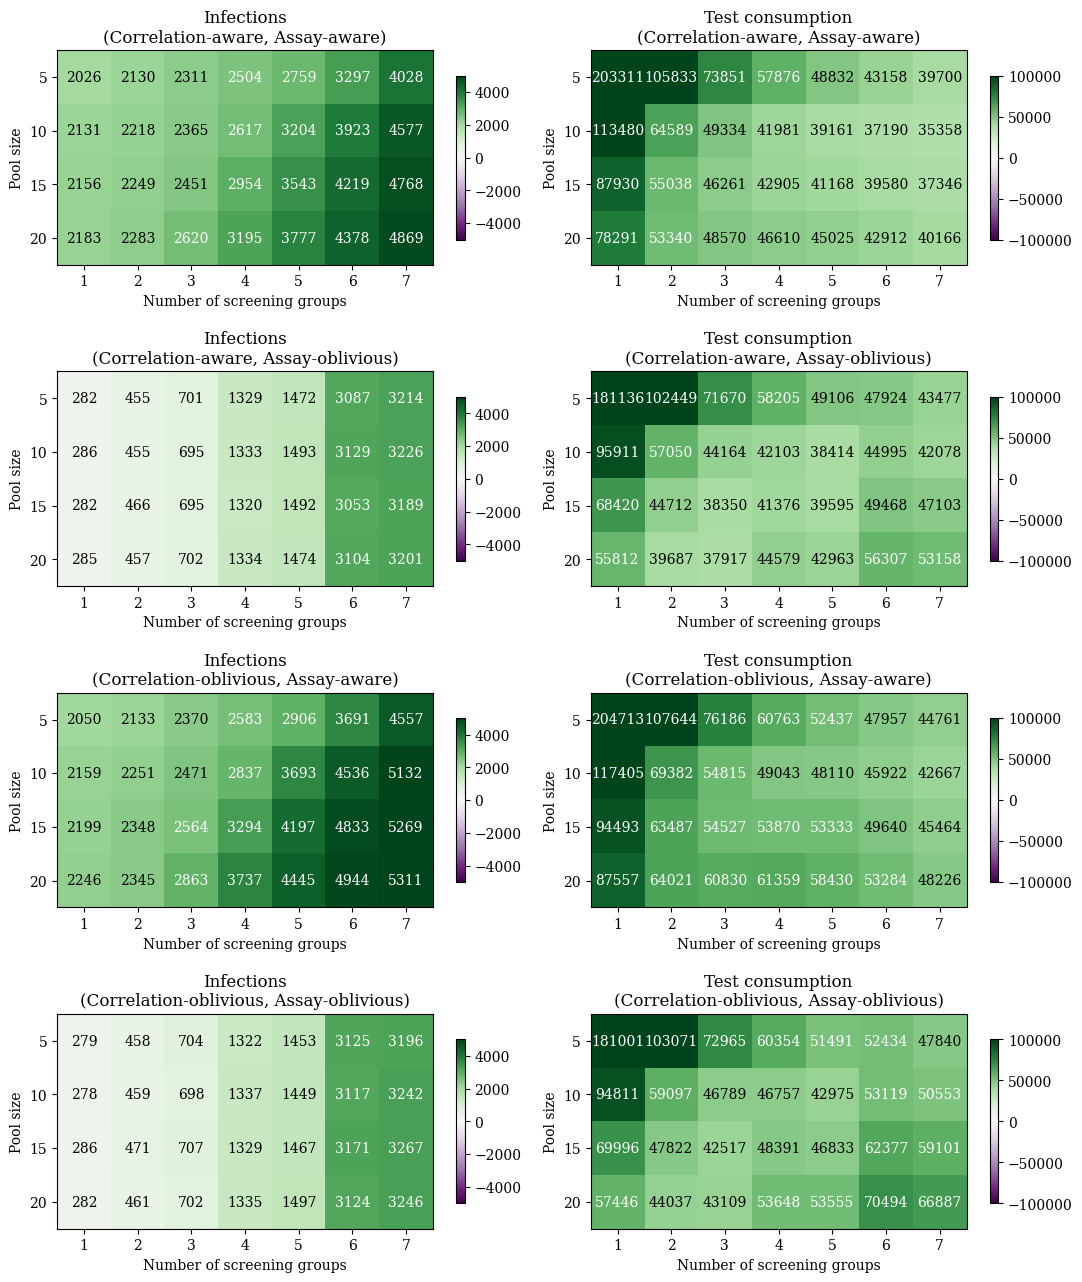

In [4]:
plt.rcParams["font.family"] = "serif"

dilute_name_mappings = {
    "average": "Assay-aware",
    "constant_0.8": "Assay-oblivious",
}
pm_name_mappings = {"np": "Correlation-oblivious", "ccp": "Correlation-aware"}

fig, axs = plt.subplots(4, 2, figsize=(11, 13))
fig.subplots_adjust(hspace=0.05, wspace=0.05)


dilute_l = ["average", "constant_0.8"]

for dilute_idx, pm_dilute in enumerate(itertools.product(["ccp", "np"], dilute_l)):
    pm, dilute = pm_dilute
    diff_inf = diffs["infections"][(pm, dilute)]
    diff_tests = diffs["tests"][(pm, dilute)]

    im_inf = axs[dilute_idx][0].imshow(
        diff_inf.transpose(), vmin=-5000, vmax=5000, cmap="PRGn"
    )
    im_tests = axs[dilute_idx][1].imshow(
        diff_tests.transpose(), vmin=-100000, vmax=100000, cmap="PRGn"
    )

    colors = ["k", "w"]

    for i, num_groups in enumerate(range(1, 8)):
        for j, pool_size in enumerate([5, 10, 15, 20]):
            # t_stat = diff[i,j] / sem_of_diffs_vals[dilute][i,j]

            cell_color_0 = im_inf.cmap(im_inf.norm(diff_inf[i, j]))
            axs[dilute_idx][0].text(
                i,
                j,
                f"{int(diff_inf[i, j])}",
                ha="center",
                va="center",
                # color=colors[np.abs(diff_inf[i, j]) > 500],
                color=colors[cell_color_0[0] < 0.5],
                fontsize=10,
            )

            cell_color_1 = im_tests.cmap(im_tests.norm(diff_tests[i, j]))
            axs[dilute_idx][1].text(
                i,
                j,
                f"{int(np.round(diff_tests[i, j]))}",
                ha="center",
                va="center",
                # color=colors[np.abs(diff_tests[i, j]) > 12000],
                color=colors[cell_color_1[0] < 0.5],
                fontsize=10,
            )

    axs[dilute_idx][0].set_title(
        f"Infections\n({pm_name_mappings[pm]}, {dilute_name_mappings[dilute]})"
    )
    axs[dilute_idx][1].set_title(
        f"Test consumption\n({pm_name_mappings[pm]}, {dilute_name_mappings[dilute]})"
    )

    fig.colorbar(
        im_inf,
        shrink=0.6,
    )
    fig.colorbar(
        im_tests,
        shrink=0.6,
    )
    for j in [0, 1]:
        axs[dilute_idx][j].set_ylabel("Pool size")
        axs[dilute_idx][j].set_yticks(range(4), [5, 10, 15, 20])
        axs[dilute_idx][j].set_xlabel("Number of screening groups")
        axs[dilute_idx][j].set_xticks(range(7), range(1, 8))

plt.tight_layout()